# Coco Manager Usage Example


In [1]:

import torch
import torchvision as tv
import torch.nn as nn

import numpy as np
from pycocotools.coco import COCO
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import itertools
import os
from typing import Dict, Tuple, List

from skimage.morphology import disk, closing
from skimage import io


## Coco_Manager Class

In [2]:

class Coco_Manager( torch.utils.data.Dataset ):
    
    def __init__( self,
                 local_imgs_path:   str=None,
                 path_ann:          str=None,
                 coco:              COCO=None,
                 pad_multiplier:    int=32 ):
        
        self.version = 1.1

        self.local_imgs_path = local_imgs_path
        self.coco = coco if coco else COCO( path_ann )
        self.ids = list(sorted(self.coco.imgs.keys()))
        print( f'(Full Set) Images found: {len(self.ids)}' )

        # Turn PIL images into Tensors
        self.transform = tv.transforms.Compose([
            tv.transforms.ToTensor()
        ])
        
        self.pad_multiplier = pad_multiplier
        self.possible_colors = self.create_colors()
        np.random.shuffle(self.possible_colors)
        

    # Colors for the masks
    def create_colors( self ) -> List[Tuple[int]]:

        perm = lambda choices, n: list(itertools.product(*[choices]*n))
        colors = perm([64*i for i in range(4)], 3) 
        return [list(rgb) for rgb in colors[1:]]


    # Adds zero-padding to be a multiple of 2^(number of upsamplings)
    def add_padding_multiple( self, img: torch.Tensor ) -> torch.Tensor:

        mul = self.pad_multiplier
        size = img.size()
        pad1 = int( np.ceil( size[1] / mul ) * mul - size[1] )
        pad2 = int( np.ceil( size[2] / mul ) * mul - size[2] )
        imgpad = nn.functional.pad(
            input=img,
            pad=(pad2, 0, pad1, 0),
            mode="constant",
            value = 0
        )
        # print( f'Added zero-padding (new size multiple of {mul}): {size} -> {imgpad.size()}' )
        return imgpad


    # If a subset of all 81 classes selected, 
    # get only images with objects from classes list.
    # Useful for semantic segmentation.
    def make_subset( self,
                    classes: List,
                    intersection: bool=False ) -> List:

        catIds = self.coco.getCatIds(catNms=classes)

        if intersection:
            true_ids = self.coco.getImgIds(catIds=catIds)
        else:
            true_ids = []
            for catId in catIds:
                true_ids = true_ids + self.coco.getImgIds(catIds=[catId])
            true_ids = list(set(true_ids))
                
        len_new = len(true_ids)
        len_old = len(self.ids)
        
        print( f'(Subset) Images found: {len_new}/{len_old} ({round(100*len_new/len_old, 2)}%)' )

        self.ids = true_ids
        self.catIds = catIds
        self.classes = classes
    

    # Gets an image from coco_url, if images themselves are not on disk
    def download_image( self, id: int ) -> Tuple[np.array, List]:
        
        imgIds = self.coco.getImgIds(imgIds = id)
        try:
            img = self.coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
            annIds = self.coco.getAnnIds( id )
            ann = self.coco.loadAnns( annIds )
        except:
            print( f"No image found with ID: {id}" )
            return None, None
        for i in range(len(ann)):
            ann[i].update({'category_name': self.coco.loadCats(ann[i]['category_id'])})

        img = np.array(io.imread(img['coco_url']))
        return img, ann


    # Shows the image and the semantic masks
    def show( self, img: np.array, anns: Dict ) -> None:
        
        with plt.style.context('dark_background'):
        
            fig, ax = plt.subplots(ncols=2, figsize=(15, 10), dpi=100)
            img = np.transpose( img.numpy(), (1, 2, 0) )

            bboxes = anns['boxes']
            labels = anns['obj_labels']
            obj_num = len(bboxes[0])

            possible_colors = self.possible_colors.copy()
            colors = {label: np.array(possible_colors.pop(0)) for label in self.classes}
            print( f'colors = {colors}' )

            # Drawing boxes on the original image
            default_color = 'lawngreen'
            for i in range(obj_num):

                # Shifting the label color to brighter hues
                label = labels[i]
                color = (colors[label[0]] / 255 + 1.5) / (1.5+1) 

                bbox = bboxes[0][i]
                rect = mpatches.Rectangle(
                    (bbox[0], bbox[1]), bbox[4], bbox[5], fill=False, edgecolor=default_color, linewidth=2)
                circle = mpatches.Circle((bbox[0]+bbox[4]//2, bbox[1]+bbox[5]//2), color=default_color)
                ax[0].add_patch( rect )
                ax[0].add_patch( circle )
                ax[0].text( bbox[0], bbox[1]-5, labels[i][0], fontdict={'color':default_color} )
        
                ax[1].text( bbox[0], bbox[1]-5, labels[i][0], fontdict={'color':color} )
                
            
            ax[0].imshow( img )
            ax[0].set_title(f'Original Image (ID: {anns["image_ids"].item()})', y=1.04)

            # Filling the empty canvas with masks
            canvas = np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
            masks = anns['masks'][0]
            
            for layer, label in enumerate(self.classes):
                
                color = colors[label]
                mask = masks[layer,:,:].numpy()
                
                for i in range(3):
                    canvas[:,:,i] += (mask * color[i]).astype(np.uint8) # // 3

            for i in range(3):
                canvas[:,:,i] = closing(canvas[:,:,i], disk(3))

            ax[1].imshow(canvas)
            ax[1].set_title('Mask from COCO annotations', y=1.04)


    def __getitem__( self, index: int ):
        
        # Dataset ID to Coco ID
        # Works in one of two modes: with local images and without
        img_id = self.ids[index]
        if self.local_imgs_path == None:
            img, coco_annotations = self.download_image( img_id )
        else:
            ann_ids = self.coco.getAnnIds( imgIds=img_id )
            coco_annotations = self.coco.loadAnns(ann_ids)
            path = self.coco.loadImgs(img_id)[0]['file_name']
            img = Image.open(os.path.join(self.local_imgs_path, path))


        # Image Transformations
        img = self.transform( img )
        img = self.add_padding_multiple( img )

        
        # If the subset is used, erase all unnecessary annotations
        if self.catIds:
            coco_annotations = [obj for obj in coco_annotations if obj['category_id'] in self.catIds ]

        # Object Labels
        num_objs = len(coco_annotations)
        for i in range(num_objs):
            coco_annotations[i].update({'category_name': self.coco.loadCats(coco_annotations[i]['category_id'])})
        obj_labels = [ ob['category_name'][0]['name'] for ob in coco_annotations ]

        # Bounding Boxes and Masks
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        masks = []
        
        # print( f'Number of Objects: {num_objs}' )
        for i in range(num_objs):
            xmin = coco_annotations[i]['bbox'][0]
            ymin = coco_annotations[i]['bbox'][1]
            xmax = xmin + coco_annotations[i]['bbox'][2]
            ymax = ymin + coco_annotations[i]['bbox'][3]
            width = coco_annotations[i]['bbox'][2]
            height = coco_annotations[i]['bbox'][3]
            
            # List of padded masks (so that img.size == mask.size)
            mask = torch.tensor(self.coco.annToMask(coco_annotations[i]))
            mask = torch.unsqueeze( mask, 0 )
            mask = self.add_padding_multiple( mask )
            masks.append( mask )
            boxes.append([xmin, ymin, xmax, ymax, width, height])
    
        # Bounding boxes aeas
        areas = [ coco_annotations[i]['area'] for i in range(num_objs) ]

        # Merge masks of the same class
        # for example: 224x224x3 image with 2 classes -> torch.Size([1, 2, 224, 224])
        # From the greatest mask to the smallest
        ordered_masks = np.zeros((len(self.classes), img.shape[1], img.shape[2]), dtype='uint8')
        for i in reversed(np.argsort(np.array(areas))):
            label = obj_labels[i]
            mask = masks[i].numpy()[0]    
            layer = self.classes.index( label )
            ordered_masks[ layer, :, : ] |= mask
            
        # Image Annotations Dictionary
        annotation = {}
        annotation["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        annotation["masks"] = torch.tensor(ordered_masks, dtype=torch.float32)
        annotation["obj_labels"] = obj_labels
        annotation["image_ids"] = torch.tensor([img_id])
        annotation["areas"] = torch.as_tensor(areas, dtype=torch.float32)

        return img, annotation
    
    def __len__( self ):
        return len( self.ids )
        

## Usage Example

In [3]:

root = '../data/COCO/'

# This path is needed if the images are downloaded on the disk
# Ignore if only annotations JSON files are on the disk
path_traindata = root + 'train2017/'
path_valdata   = root + 'val2017/'

# This path is needed anyway to create a coco object
# It contains masks, bboxes and download URLs
path_trainjson = root + 'annotations/instances_train2017.json'
path_valjson   = root + 'annotations/instances_val2017.json'


In [4]:
# # Colab Stuff
# from google.colab import drive
# drive.mount('/content/drive')
# root = "/content/drive/MyDrive/"
# path_trainjson = root + "Projects/FCN/annotations_trainval2017/annotations/instances_train2017.json"
# path_valjson   = root + "Projects/FCN/annotations_trainval2017/annotations/instances_val2017.json"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

# Using both local images and annotations:
# coco = COCO( path_trainjson )
# coco_manager = Coco_Manager( coco=coco, local_imgs_path=path_traindata )

# Another way
# (coco object is created inside, in Jupyter it's faster to create coco before):
# coco_manager = Coco_Manager( path_ann=path_trainjson, local_imgs_path=path_traindata )

# Using only annotations:
coco_manager = Coco_Manager( path_ann=path_trainjson )


loading annotations into memory...
Done (t=24.69s)
creating index...
index created!
(Full Set) Images found: 118287


In [6]:

# Making a subset of the dataset

# Searches for all the images with both classes present simultaneously
coco_manager.make_subset( classes=['person', 'cat'], intersection=True )

# Images with the first class or the second (or both)
# coco_manager.make_subset( classes=['person', 'cat'], intersection=False )


(Subset) Images found: 693/118287 (0.59%)


In [7]:

# Pytorch DataLoader creation
# Dynamic batching cooming soon
batch_size = 1
loader_test = torch.utils.data.DataLoader( coco_manager, batch_size=1, shuffle=True )
dataiter = iter(loader_test)


In [8]:

# Random image
# (Coco images have different shapes)
image, annotations = dataiter.next()
image = image[0]
image.shape


torch.Size([3, 480, 640])

In [9]:

# 'boxes':                    Tensors [xmin, ymin, xmax, ymax, width, height]
# 'masks':                    Tensors of shape [ batch_size, num_classes, img_width, img_height ]
# 'label_2_semantic_layer':   Mapping of the Coco class to an integer on the mask
# 'labels':                   Coco classes
# 'image_ids':                Image Coco ID
# 'areas':                    Areas of the bounding boxes

annotations.keys()


dict_keys(['boxes', 'masks', 'obj_labels', 'image_ids', 'areas'])

In [10]:

# Mask of this image
mask = annotations['masks'][0]
print( mask.size() )
print( np.unique(mask[0,:,:]) )


torch.Size([2, 480, 640])
[0. 1.]


colors = {'person': array([ 64,  64, 128]), 'cat': array([  0, 192, 192])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


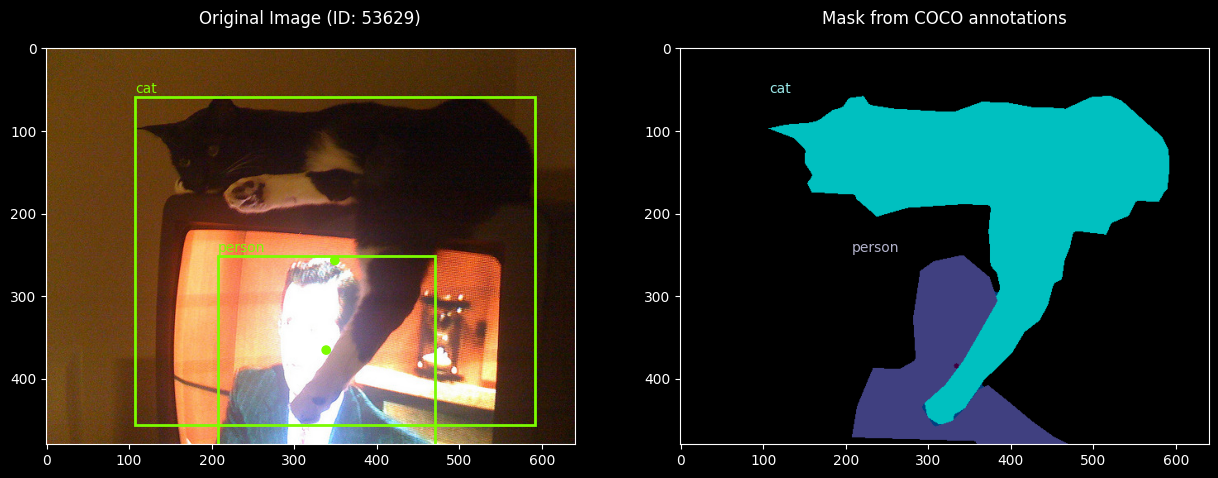

In [11]:

# Display
coco_manager.show(image, annotations)
